In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
from dataclasses import dataclass, field

import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

from generator import generate_tracks_paper, generate_tracks_time_varying, generate_tracks_sudden_birth, generate_measurements, \
    generate_clutter

from gmphd_fusion.data import Track, StateVector, CovarianceMatrix, StateVectors
from gmphd_fusion.filter import KalmanFilter
from gmphd_fusion.gm import Gaussian, GaussianMixture
from gmphd_fusion.gmphd import GMPHD
from gmphd_fusion.measurement_model import LinearCoordinateMeasurementModel, MeasurementModel
from gmphd_fusion.metrics import cpep_tracks, eae_targets_number
from gmphd_fusion.motion_models import ConstantVelocityMotionModel, MotionModel
from gmphd_fusion.util import set_seed
from gmphd_fusion.visualize import visualize_mixture, visualize_trajectories

In [3]:
plt.style.use("bmh")
plt.rcParams.update({"figure.figsize": (24, 12),
                     "axes.facecolor": "white",
                     "axes.edgecolor": "black"})

In [4]:
@dataclass
class TestUseCase2D:
    surveillance_region: tuple[tuple[float, float], tuple[float, float]]
    clutter_rate: int
    detection_prob: float
    survival_prob: float
    prune_threshold: float
    merge_threshold: float
    max_components: int
    init_gm: GaussianMixture
    birth_gm: GaussianMixture
    motion_model: MotionModel
    measurement_model: MeasurementModel
    cpep_radius: float
    tracks_true: list[Track]
    target_weight_threshold: float = 0.5
    track_min_len: int = 1
    random_seed: int | None = None
    samples_per_test: int = 100
    # fuse gaussians (values) at time k (keys)
    fuse: dict[int, GaussianMixture] = field(default_factory=dict)

    @property
    def xmin(self) -> float:
        return self.surveillance_region[0][0]

    @property
    def xmax(self) -> float:
        return self.surveillance_region[1][0]

    @property
    def xlim(self) -> tuple[int, int]:
        return int(self.xmin * 1.1), int(self.xmax * 1.1)

    @property
    def ymin(self) -> float:
        return self.surveillance_region[0][1]

    @property
    def ymax(self) -> float:
        return self.surveillance_region[1][1]

    @property
    def ylim(self) -> tuple[int, int]:
        return int(self.ymin * 1.1), int(self.ymax * 1.1)

    @property
    def unif_min(self) -> np.ndarray:
        return np.array(self.surveillance_region).T[:, 0:1]

    @property
    def unif_max(self) -> np.ndarray:
        return np.array(self.surveillance_region).T[:, 1:2]

    @property
    def surveillance_area(self) -> float:
        return float(np.prod(np.diff(np.array(self.surveillance_region), axis=0)))

    @property
    def clutter_spatial_density(self) -> float:
        return self.clutter_rate / self.surveillance_area

# Define testing use cases

In [5]:
# Change of parameters that we are going to measure
TEST_PARAMS = dict(
    clutter_rate=[5. * (i + 1) for i in range(10)],
    detection_prob=[0.5 + 0.05 * (i + 1) for i in range(10)],
)
TEST_CASES = dict(
    two_obj_cross=TestUseCase2D(
        surveillance_region=((-1000., -1000.), (1000., 1000.)),
        clutter_rate=50,
        detection_prob=0.98,
        survival_prob=0.99,
        prune_threshold=1e-5,
        merge_threshold=4,
        max_components=1000,
        init_gm=GaussianMixture(),
        birth_gm=GaussianMixture(
            gaussians=[
                Gaussian(
                    mean=StateVector([250, 250, 0, 0]),
                    cov=CovarianceMatrix(np.diag([100, 100, 25, 25])),
                    label=Gaussian.BIRTH_LABEL),
                Gaussian(
                    mean=StateVector([-250, -250, 0, 0]),
                    cov=CovarianceMatrix(np.diag([100, 100, 25, 25])),
                    label=Gaussian.BIRTH_LABEL),
            ],
            weights=[0.1, 0.1],
        ),
        motion_model=ConstantVelocityMotionModel(motion_noise=5),
        measurement_model=LinearCoordinateMeasurementModel(dim_measurement=2, dim_state=4, measurement_noise=10),
        tracks_true=generate_tracks_paper(),
        cpep_radius=20,
        target_weight_threshold=0.5,
    ),
    birth_death_vary=TestUseCase2D(
        surveillance_region=((-1000., -1000.), (1000., 1000.)),
        clutter_rate=50,
        detection_prob=0.98,
        survival_prob=0.99,
        prune_threshold=1e-5,
        merge_threshold=4,
        max_components=1000,
        init_gm=GaussianMixture(),
        birth_gm=GaussianMixture(
            gaussians=[
                Gaussian(
                    mean=StateVector([-1000, 750, 0, 0]),
                    cov=CovarianceMatrix(np.diag([100, 100, 30, 30])),
                    label=Gaussian.BIRTH_LABEL),
                Gaussian(
                    mean=StateVector([1000, -750, 0, 0]),
                    cov=CovarianceMatrix(np.diag([100, 100, 30, 30])),
                    label=Gaussian.BIRTH_LABEL),
            ],
            weights=[0.1, 0.1],
        ),
        motion_model=ConstantVelocityMotionModel(motion_noise=5),
        measurement_model=LinearCoordinateMeasurementModel(dim_measurement=2, dim_state=4, measurement_noise=10),
        tracks_true=generate_tracks_time_varying(),
        cpep_radius=20,
        target_weight_threshold=0.5,
    ),
    birth_no_fusion=TestUseCase2D(
        surveillance_region=((-1000., -1000.), (1000., 1000.)),
        clutter_rate=50,
        detection_prob=0.98,
        survival_prob=0.99,
        prune_threshold=1e-5,
        merge_threshold=4,
        max_components=1000,
        init_gm=GaussianMixture(),
        birth_gm=GaussianMixture(
            gaussians=[
                Gaussian(
                    mean=StateVector([-1000, 750, 0, 0]),
                    cov=CovarianceMatrix(np.diag([100, 100, 30, 30])),
                    label=Gaussian.BIRTH_LABEL),
                Gaussian(
                    mean=StateVector([1000, -750, 0, 0]),
                    cov=CovarianceMatrix(np.diag([100, 100, 30, 30])),
                    label=Gaussian.BIRTH_LABEL),
            ],
            weights=[0.1, 0.1],
        ),
        motion_model=ConstantVelocityMotionModel(motion_noise=5),
        measurement_model=LinearCoordinateMeasurementModel(dim_measurement=2, dim_state=4, measurement_noise=10),
        tracks_true=generate_tracks_sudden_birth(),
        cpep_radius=20,
        target_weight_threshold=0.5,
    ),
    birth_fusion=TestUseCase2D(
        surveillance_region=((-1000., -1000.), (1000., 1000.)),
        clutter_rate=50,
        detection_prob=0.98,
        survival_prob=0.99,
        prune_threshold=1e-5,
        merge_threshold=4,
        max_components=1000,
        init_gm=GaussianMixture(),
        birth_gm=GaussianMixture(
            gaussians=[
                Gaussian(
                    mean=StateVector([-1000, 750, 0, 0]),
                    cov=CovarianceMatrix(np.diag([100, 100, 30, 30])),
                    label=Gaussian.BIRTH_LABEL),
                Gaussian(
                    mean=StateVector([1000, -750, 0, 0]),
                    cov=CovarianceMatrix(np.diag([100, 100, 30, 30])),
                    label=Gaussian.BIRTH_LABEL),
            ],
            weights=[0.1, 0.1],
        ),
        motion_model=ConstantVelocityMotionModel(motion_noise=5),
        measurement_model=LinearCoordinateMeasurementModel(dim_measurement=2, dim_state=4, measurement_noise=10),
        tracks_true=generate_tracks_sudden_birth(),
        fuse={
            20: GaussianMixture(
                gaussians=[Gaussian(StateVector([-1050, -1050, 25, 25]), cov=CovarianceMatrix(np.diag([100, 100, 10, 10])), label=None)],
                weights=[0.6],
            ),
            60: GaussianMixture(
                gaussians=[Gaussian(StateVector([1020, 1020, -22, -22]), cov=CovarianceMatrix(np.diag([40, 40, 5, 5])), label=None)],
                weights=[0.7],
            ),
        },
        cpep_radius=20,
        target_weight_threshold=0.5,
    ),
)

Run test: birth_no_fusion


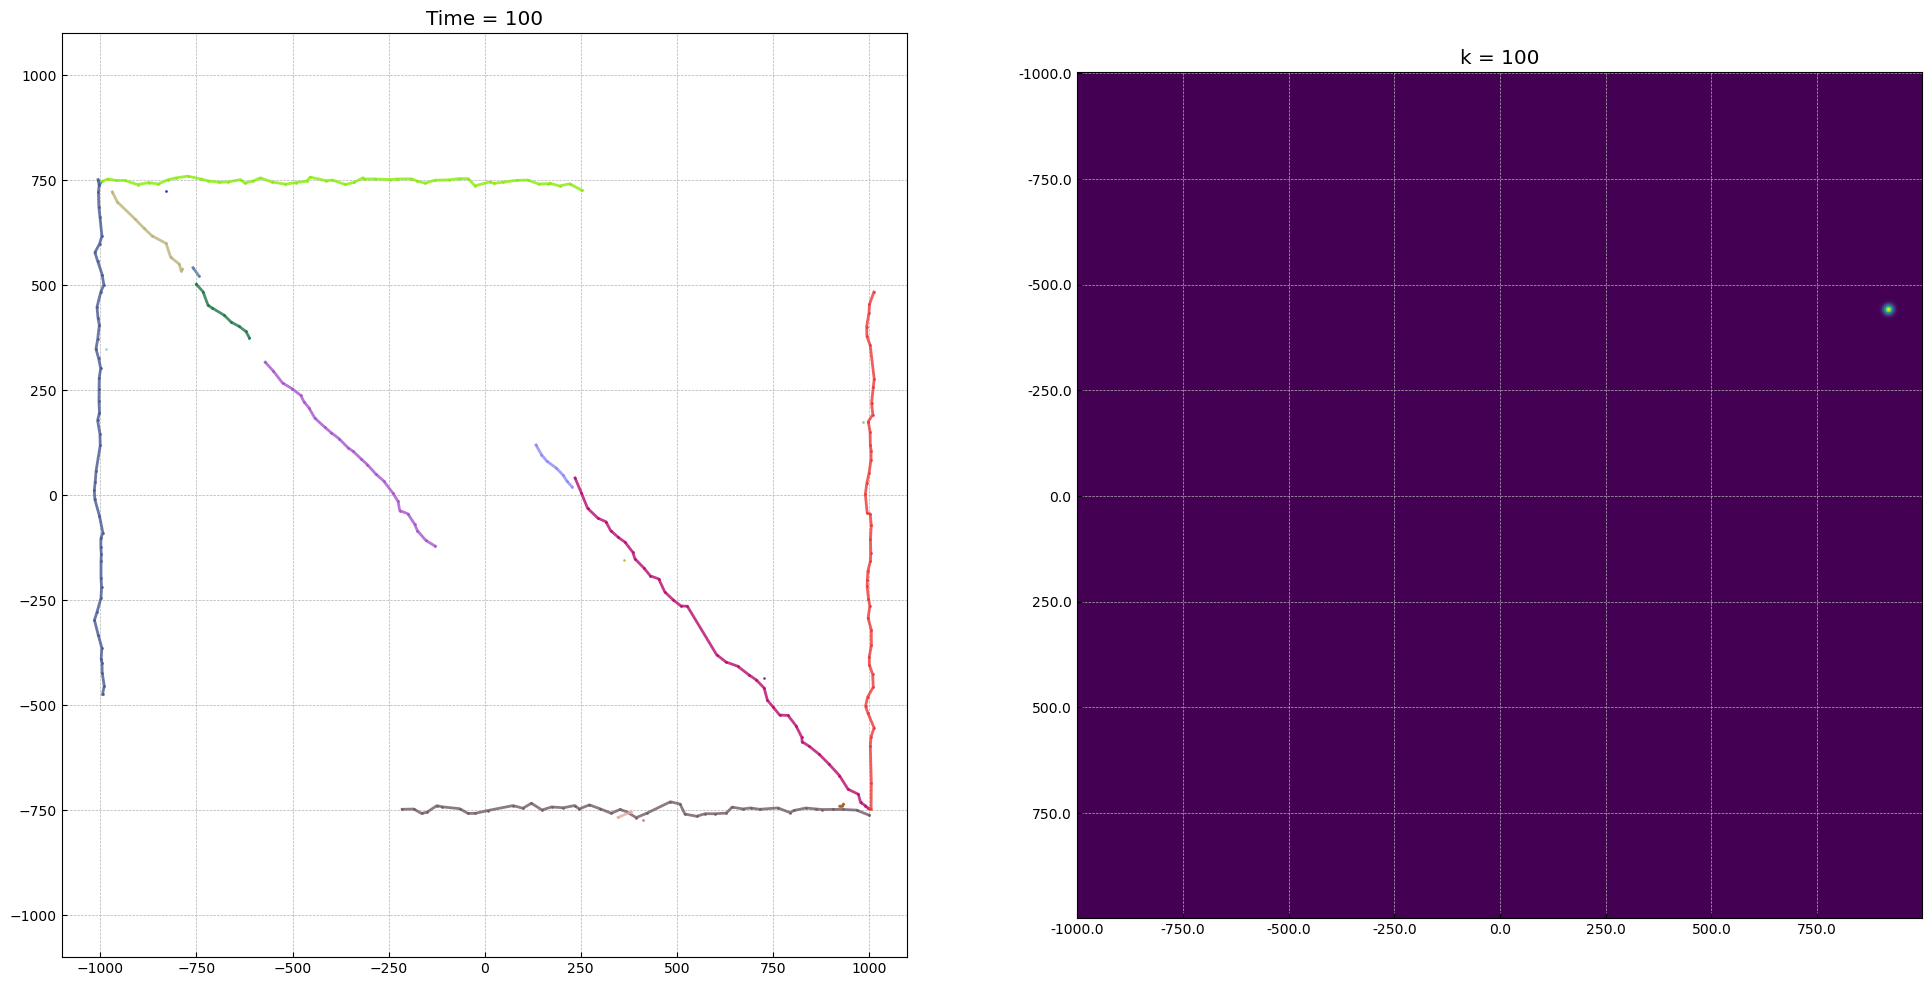

CPEP: 0.8565
EAE: 0.96


In [7]:
for test_name, uc in TEST_CASES.items():
    if test_name != "birth_no_fusion":
        continue
    print(f"Run test: {test_name}")

    set_seed(uc.random_seed)
    kalman_filter = KalmanFilter()
    gmphd = GMPHD(
        init_gm=uc.init_gm,
        birth_gm=uc.birth_gm,
        filter=kalman_filter,
        motion_model=uc.motion_model,
        measurement_model=uc.measurement_model,
        clutter_spatial_density=uc.clutter_spatial_density,
        detection_prob=uc.detection_prob,
        survival_prob=uc.survival_prob,
        prune_threshold=uc.prune_threshold,
        merge_threshold=uc.merge_threshold,
        max_components=uc.max_components,
        target_weight_threshold=uc.target_weight_threshold,
    )
    measurements = [generate_measurements(t, uc.measurement_model, detection_prob=uc.detection_prob) for t in uc.tracks_true]
    clutter = generate_clutter(uc.samples_per_test, uc.clutter_rate, uc.unif_min, uc.unif_max)

    for time in range(uc.samples_per_test):
        # fuse gaussians before acquiring measurements
        if time in uc.fuse:
            for gaussian, weight in uc.fuse[time]:
                gmphd.fuse(gaussian, weight)
        measurements_k = [t.estimate_at(time) for t in measurements]
        measurements_k = filter(lambda e: e is not None, measurements_k)
        measurements_k = list(measurements_k)
        clutter_k = clutter[time]
        meas_clut = StateVectors([*measurements_k, clutter_k])
        gmphd.step(meas_clut, timestamp=time + 1)

    tracks = gmphd.get_tracks(min_length=uc.track_min_len)

    # generate plots
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set_xlim(*uc.xlim)
    ax1.set_ylim(*uc.ylim)
    ax1.set_facecolor("white")

    x_res = y_res = 500
    ax2.set_xticks(np.linspace(0, x_res, num=9), np.linspace(uc.xmin, uc.xmax, num=9))
    ax2.set_yticks(np.linspace(0, y_res, num=9), np.linspace(uc.ymin, uc.ymax, num=9))

    visualize_trajectories(
        axis=ax1,
        ground_truth=None,  #uc.tracks_true,
        estimates=tracks,
        measurements=None,  #np.hstack(measurements),
        clutter=None,  #np.hstack(clutter),
        time=uc.samples_per_test,
    )
    visualize_mixture(
        axis=ax2,
        mixture=gmphd.posterior,
        time=uc.samples_per_test,
        xlim=uc.xlim,
        ylim=uc.ylim,
        x_res=x_res,
        y_res=y_res,
    )
    plt.show()

    # compute metrics
    state_extraction_matrix = uc.measurement_model.measurement_matrix()
    ntargets_true = []
    ntargets_est = []
    cpep_over_time = []

    for time in range(1, uc.samples_per_test + 1):
        ntt_k = [1 for t in uc.tracks_true if t.estimate_at(time) is not None]
        nte_k = [1 for t in tracks if t.estimate_at(time) is not None]
        ntargets_true.append(sum(ntt_k))
        ntargets_est.append(sum(nte_k))

        cpep_k = cpep_tracks(uc.tracks_true, tracks, time, uc.cpep_radius, state_extraction_matrix)
        cpep_over_time.append(cpep_k)

    eae = eae_targets_number(ntargets_true, ntargets_est)
    print(f"CPEP: {np.mean(cpep_over_time)}")
    print(f"EAE: {eae}")